In [1]:
# this notebook visualizes the result of trained models, what types of defect they didn't correctly
# recognize
# author: Zhaonan Li zli@brandeis.edu
# created at: 6/6/2019

import pandas as pd
import numpy as np
from confidence_map_helper import checkYolo, putBackYOLO, compareLabels
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image, ImageOps
import torchvision

In [2]:
window_size = 0.15

df_yolo = pd.read_csv('/home/zli/yolo2_dm/results/test_yolo.csv', sep=' ')
df_truth = pd.read_csv('/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/csv_labels/test.csv', sep=" ")
df_MMN = pd.read_csv('/home/zli/yolo2_dm/results/test_MMN.csv', sep=' ')

# columns = ['image_index','class', 'x', 'y']
# df_yolo_points = pd.DataFrame(index=np.arange(len(df_yolo)), columns=columns)
# df_yolo_points['image_index'] = df_yolo['image_index']
# df_yolo_points['class'] = df_yolo['class']
# df_yolo_points['x'] = (df_yolo['x1'] + df_yolo['x2'])/2
# df_yolo_points['y'] = (df_yolo['y1'] + df_yolo['y2'])/2

df_yolo_points = df_yolo.copy()
df_yolo_points['x'] = (df_yolo['x1'] + df_yolo['x2'])/2
df_yolo_points['y'] = (df_yolo['y1'] + df_yolo['y2'])/2
df_yolo_points.drop(['x1', 'y1', 'x2', 'y2'], axis=1, inplace=True)

                   # class 0,   1,    2,    3
confidence_threshold = [0.24, 0.1, 0.12, 0.06]
classes_masks = [df_yolo_points['class'] == x for x in range(4)]

confidence_threshold = [0.24, 0.1, 0.12, 0.06]
for c in range(4):
    # select rows with low confidence and remove
    confidence_mask = df_yolo_points[classes_masks[c]]['confidence'] < confidence_threshold[c]
    confidence_mask = confidence_mask.index[confidence_mask.values]

    df_yolo_points.drop(confidence_mask, inplace=True)
    
df_yolo_points.info
        
df_MMN = df_MMN.drop(columns = ['confidence'])
new_order = [1,0,2,3]
df_MMN = df_MMN[df_MMN.columns[new_order]]

/home/zli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
# df_yolo_points.info

In [4]:
df_yolo_points.to_csv('yolo_6-6-19.csv', sep=' ', index=False, header=False)

valid = np.concatenate((np.arange(6501,7001),np.arange(8201,8234),np.arange(8801,8834)))
test = np.concatenate((np.arange(7001,8001),np.arange(8234,8301),np.arange(8834,8901)))
# test = np.arange(7001, 8000)

In [5]:
columns = ['image_index','class', 'x', 'y']
df_results = pd.DataFrame(index=np.arange(0), columns=columns)
# df_truth = df_truth[(df_truth['image_index'] <= 8900) & (df_truth['image_index'] >= 8801)]
# df_test = df_truth.loc[df_truth['image_index'].isin(np.arange(6501,6601))]
for i in test:# detecting local maxima in confidence map to find defects
    columns = ['image_index','class', 'x', 'y']
    df_img = pd.DataFrame(index=np.arange(0), columns=columns)
    
    arr_pos = np.load('/home/zli/convolution_test/pos/%06.0f.npy' % i)
    arr_neg = np.load('/home/zli/convolution_test/neg/%06.0f.npy' % i)
    arr_pos_o = np.load('/home/zli/convolution_test/pos_o/%06.0f.npy' % i)
    arr_nuc = np.load('/home/zli/convolution_test/nuc/%06.0f.npy' % i)
    
    coord_pos = peak_local_max(arr_pos, min_distance=15, threshold_abs=0.983, threshold_rel = 0.9).astype(float)
    coord_neg = peak_local_max(arr_neg, min_distance=8, threshold_abs=0.988, threshold_rel = 0.9).astype(float)
    coord_pos_o = peak_local_max(arr_pos_o, min_distance=12, threshold_abs=0.97, threshold_rel = 0.9).astype(float)
    coord_nuc = peak_local_max(arr_nuc, min_distance=12, threshold_abs=0.93, threshold_rel = 0.9).astype(float)
    
    coord_pos[:,0], coord_pos[:,1] = coord_pos[:,0]/150.0, coord_pos[:,1]/150.0
    coord_neg[:,0], coord_neg[:,1] = coord_neg[:,0]/150.0, coord_neg[:,1]/150.0
    coord_pos_o[:,0], coord_pos_o[:,1] = coord_pos_o[:,0]/150.0, coord_pos_o[:,1]/150.0
    coord_nuc[:,0], coord_nuc[:,1] = coord_nuc[:,0]/150.0, coord_nuc[:,1]/150.0
    
    df_pos = pd.DataFrame(index=np.arange(coord_pos.shape[0]), columns=columns)
    df_neg = pd.DataFrame(index=np.arange(coord_neg.shape[0]), columns=columns)
    df_pos_o = pd.DataFrame(index=np.arange(coord_pos_o.shape[0]), columns=columns)
    df_nuc = pd.DataFrame(index=np.arange(coord_nuc.shape[0]), columns=columns)
    
    df_pos['class'] = 0
    df_neg['class'] = 1
    df_pos_o['class'] = 2
    df_nuc['class'] = 3
    
    df_pos['x'], df_pos['y'] = coord_pos[:,1], 1 - coord_pos[:,0]
    df_neg['x'], df_neg['y'] = coord_neg[:,1], 1 - coord_neg[:,0]
    df_pos_o['x'], df_pos_o['y'] = coord_pos_o[:,1], 1 - coord_pos_o[:,0]
    df_nuc['x'], df_nuc['y'] = coord_nuc[:,1], 1 - coord_nuc[:,0]
    
    df_img = df_img.append(df_pos, ignore_index=True)
    df_img = df_img.append(df_neg, ignore_index=True)
    df_img = df_img.append(df_pos_o, ignore_index=True)
    df_img = df_img.append(df_nuc, ignore_index=True)
    
    df_img['image_index'] = i
    df_results = df_results.append(df_img, ignore_index=True)

In [6]:
df_results_yolo = checkYolo(conf_thres_pos = 0.001, conf_thres_neg = 0.001, conf_thres_nuc = 0.001, conf_thres_pos_o = 0.001, df_yolo = df_yolo.replace({'class':2},0), df_results = df_results.replace({'class':2},0))
df_results_yolo = putBackYOLO(window_size = 0.20, conf_thres_pos = 0.7, conf_thres_neg = 0.8, conf_thres_nuc = 1, conf_thres_pos_o = 0.9, df_yolo = df_yolo, df_results = df_results_yolo.replace({'class':2},0))
df_results_yolo = df_results_yolo.replace({'class':2},0)
# df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)

In [7]:
# compares prediction with groud truth, categorizes each prediction as correct or incorrect, and each annotated point as
# predicted and not predicted

def eval_pred(df_truth, cur_df_truth_mask, df_results, cur_df_pred_mask):
    
    if len(df_truth.loc[cur_df_truth_mask]) == 0 and len(df_results[cur_df_pred_mask]) == 0:
        df_truth.loc[cur_df_truth_mask, 'category'] = None
        df_results.loc[cur_df_pred_mask, 'category'] = None
        return df_truth.loc[cur_df_truth_mask], df_results.loc[cur_df_pred_mask]
    
    if len(df_truth.loc[cur_df_truth_mask]) == 0:
        df_results.loc[cur_df_pred_mask, 'category'] = 0
        return df_truth.loc[cur_df_truth_mask], df_results.loc[cur_df_pred_mask]
    
    if len(df_results.loc[cur_df_pred_mask]) == 0:
        df_truth.loc[cur_df_truth_mask, 'category'] = 0
        return df_truth.loc[cur_df_truth_mask], df_results.loc[cur_df_pred_mask]
    
    df_truth.loc[cur_df_truth_mask, 'category'] = 0
    df_results.loc[cur_df_pred_mask, 'category'] = 0
    
    for index_t, row_t in df_truth.loc[cur_df_truth_mask].iterrows():
        xt, yt = row_t.x, row_t.y
        dis = [np.linalg.norm(np.array([xt, yt]) - np.array([rowp.x, rowp.y])) for index, rowp in df_results.loc[cur_df_pred_mask].iterrows()]
        ind = [index for index, rowp in df_results.loc[cur_df_pred_mask].iterrows()]
        
        if np.min(dis) < window_size/2:
            df_truth.loc[index_t, 'category'] = 1
            df_results.loc[ind[np.argmin(dis)], 'category'] = 1
            
    return df_truth.loc[cur_df_truth_mask], df_results.loc[cur_df_pred_mask]


In [8]:
# input: df_truth and df_results
# output: df_truth and df_results with category column added in-place. 1 in category represents correct prediction,
# 0 represents failed prediction

# types of defects
classes = [0, 1, 2, 3]

#index: tot,p,n,p_o,nuc 
truth = [0, 0, 0, 0, 0]
correct = [0, 0, 0, 0, 0]
predict = [0, 0, 0, 0, 0]

#index:p, n, po, nuc
dis = [0, 0, 0, 0]
dis_c = [0, 0, 0, 0]

# for i in df_truth['image_index'].unique():
for i in test:
    df_truth_mask = df_truth['image_index'] == i
    df_results_mask = df_results['image_index'] == i
    
    for c in classes:
        cur_df_truth_mask = df_truth_mask & (df_truth['class'] == c)
        cur_df_pred_mask  = df_results_mask & (df_results['class'] == c)

        eval_result = eval_pred(df_truth, cur_df_truth_mask, df_results, cur_df_pred_mask)

print(df_truth)
print(df_results)

      image_index  class         x         y  category
0            6501      0  0.240489  0.560160       NaN
1            6501      0  0.445652  0.383690       NaN
2            6501      0  0.514946  0.774064       NaN
3            6501      1  0.153533  0.605615       NaN
4            6501      3  0.205842  0.642380       NaN
5            6502      0  0.241848  0.561497       NaN
6            6502      0  0.440217  0.385027       NaN
7            6502      0  0.512228  0.770053       NaN
8            6502      1  0.156250  0.605615       NaN
9            6502      3  0.201766  0.650401       NaN
10           6503      0  0.251359  0.570856       NaN
11           6503      0  0.441576  0.391711       NaN
12           6503      0  0.524457  0.770053       NaN
13           6503      1  0.156250  0.604278       NaN
14           6503      3  0.204484  0.651738       NaN
15           6504      0  0.250000  0.568182       NaN
16           6504      0  0.433424  0.389037       NaN
17        

In [9]:
def get_data_img(img_index, x, y, window_size=50, pad_size=50, data_transform=None):
    img_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/'
    img = Image.open(img_path + '%06.0f.jpg' % img_index)
    img = img.convert('L')
    img = torchvision.transforms.functional.resize(img, (300,300), interpolation=2)
    width, height = img.size
    img = ImageOps.expand(img, border=pad_size, fill=0)
    xmin = width * x - window_size/2 + pad_size
    ymin = height * y - window_size/2 + pad_size
    xmax = width * x + window_size/2 + pad_size
    ymax = height * y + window_size/2 + pad_size
    img = img.crop((xmin, ymin, xmax, ymax))
    
    img = torchvision.transforms.functional.resize(img, (200, 200), interpolation=2)
    return img

<Figure size 2160x12960 with 0 Axes>

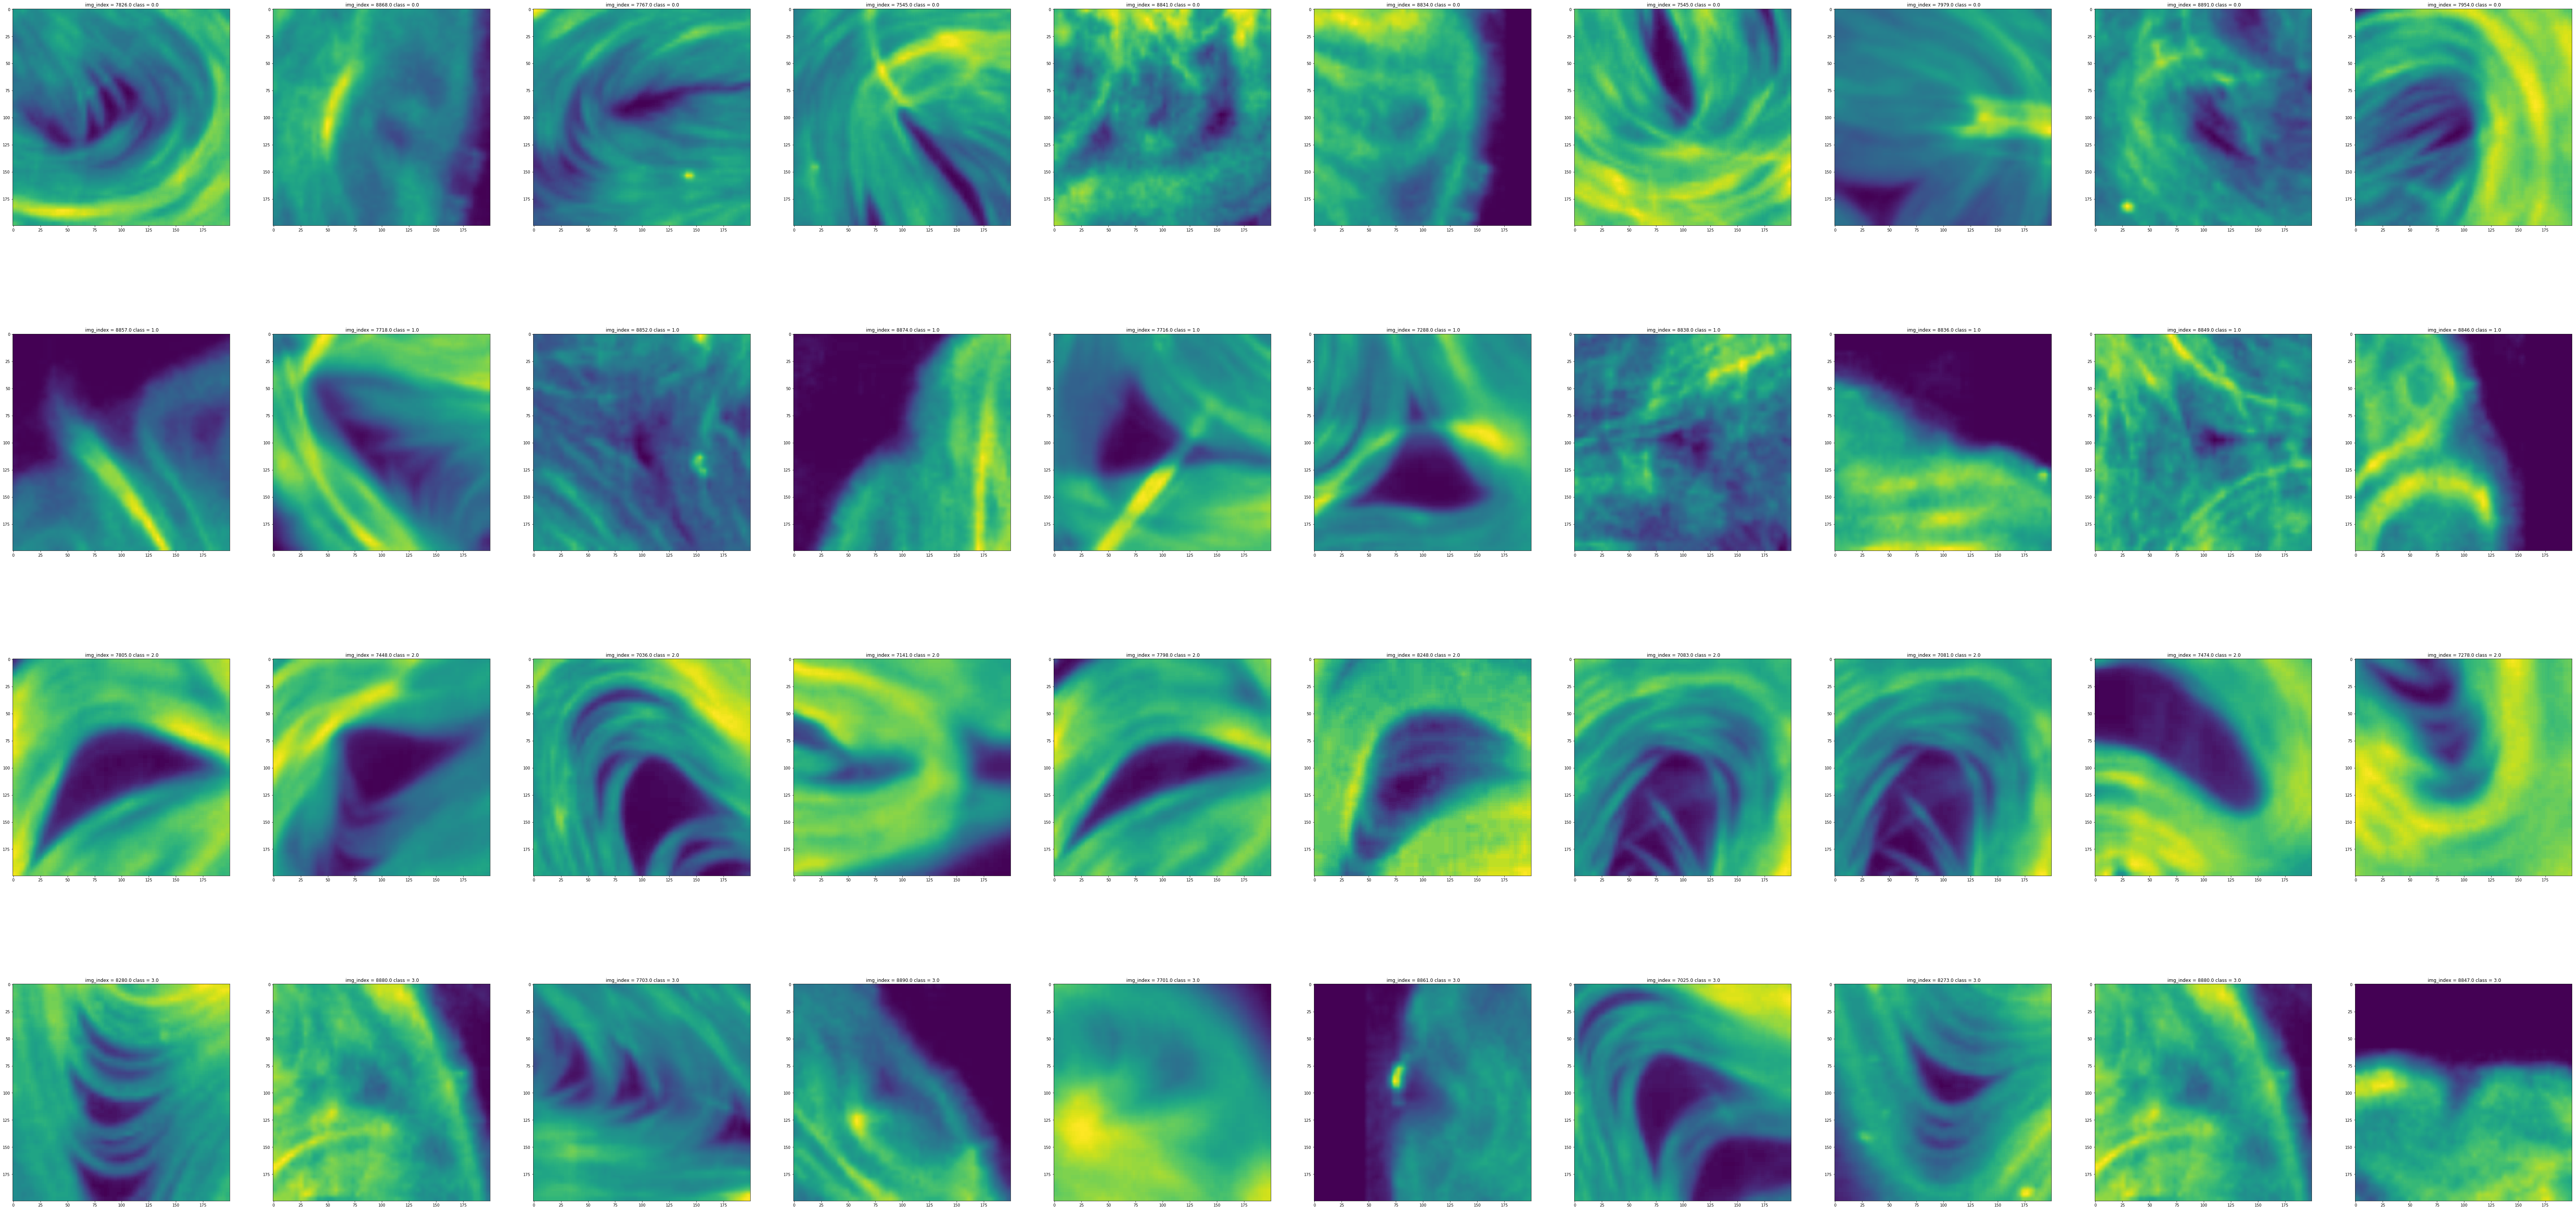

In [55]:
false_positive = df_results[df_results['category'] == 0]
false_negative = df_truth[df_truth['category'] == 0]
true_positive  = df_results[df_results['category'] == 1]

# visualize data points in dataframe
def visualize_points(df, title="", num=10, window_size=50, seed=None):     
    fig = plt.figure(figsize=(30, 180))

#     types = df['class'].unique()
    types = [0, 1, 2, 3]
    types_masks = [df['class'] == t for t in types]
    
    fig = plt.figure(figsize=(120, 60))
    index = 1
    
    for t in types:
        cur_type_mask = types_masks[t]
        if seed is not None:
            np.random.seed(seed)
        indices = np.random.randint(len(df.loc[cur_type_mask]), size=num)
        for i in indices:
            cur_data = df.loc[cur_type_mask].iloc[i]
            img = get_data_img(cur_data.image_index, cur_data.x, 1 - cur_data.y)
            
            ax = plt.subplot(len(types), num, index)
            ax.set_title(title + " img_index = " + str(cur_data.image_index) + " class = " + str(cur_data['class']))
            plt.imshow(img)
            
            index += 1    

visualize_points(false_negative)

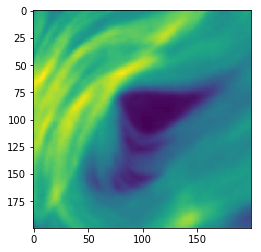

In [48]:
def display_image_by_index(img_index):
    fig = plt.figure(figsize=(60, 60))
    img_path = '/home/rliu/yolo2/v2_pytorch_yolo2/data/an_data/VOCdevkit/VOC2007/JPEGImages/'
    img = Image.open(img_path + '%06.0f.jpg' % img_index)
    img = img.convert('L')
    plt.imshow(img)

plt.imshow(get_data_img(7444,0.63,1-0.23, window_size = 70))
# display_image_by_index(7444)

In [12]:
# df_truth = df_truth.loc[df_truth['image_index'].isin(test)]
# df = compareLabels(df_results_yolo.replace({'class':2},0), df_truth.replace({'class':2},0), window_size=window_size)
# precision_tot = df.loc[0,'correct_tot'] / df.loc[0,'pred_tot']
# precision_pos = df.loc[0,'correct_pos'] / df.loc[0,'pred_pos']
# precision_neg = df.loc[0,'correct_neg'] / df.loc[0,'pred_neg']
# precision_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'pred_pos_o']
# precision_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'pred_nuc']

# recall_tot = df.loc[0,'correct_tot'] / df.loc[0,'truth_tot']
# recall_pos = df.loc[0,'correct_pos'] / df.loc[0,'truth_pos']
# recall_neg = df.loc[0,'correct_neg'] / df.loc[0,'truth_neg']
# recall_pos_o = df.loc[0,'correct_pos_o'] / df.loc[0,'truth_pos_o']
# recall_nuc = df.loc[0,'correct_nuc'] / df.loc[0,'truth_nuc']

# accuracy_tot = 2*(precision_tot*recall_tot)/(precision_tot+recall_tot)
# accuracy_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
# accuracy_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
# accuracy_pos_o = 2*(precision_pos_o*recall_pos_o)/(precision_pos_o+recall_pos_o)
# accuracy_nuc = 2*(precision_nuc*recall_nuc)/(precision_nuc+recall_nuc)

# precision_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'pred_pos']+df.loc[0,'pred_neg'])
# recall_pn = (df.loc[0,'correct_pos']+df.loc[0,'correct_neg'])/ (df.loc[0,'truth_pos']+df.loc[0,'truth_neg'])
# accuracy_pn = 2*(precision_pn*recall_pn)/(precision_pn+recall_pn)

# dis_pos_c = df.loc[0,'dis_pos_c'] / df.loc[0,'correct_pos']
# dis_neg_c = df.loc[0,'dis_neg_c'] / df.loc[0,'correct_neg']
# dis_pos_o_c = df.loc[0,'dis_pos_o_c'] / df.loc[0,'correct_pos_o']
# dis_nuc_c = df.loc[0,'dis_nuc_c'] / df.loc[0,'correct_nuc']



# print('precision_tot =', precision_tot)
# print('precision_pos =', precision_pos)
# print('precision_neg =', precision_neg)
# print('precision_pos_o =', precision_pos_o)
# print('precision_nuc =', precision_nuc)
# print('precision_pn =', precision_pn)
# print('\n')
# print('recall_tot =', recall_tot)
# print('recall_pos =', recall_pos)
# print('recall_neg =', recall_neg)
# print('recall_pos_o =', recall_pos_o)
# print('recall_nuc =', recall_nuc)
# print('recall_pn =', recall_pn)
# print('\n')
# print('accuracy_tot =', accuracy_tot)
# print('accuracy_pos =', accuracy_pos)
# print('accuracy_neg =', accuracy_neg)
# print('accuracy_pos_o =', accuracy_pos_o)
# print('accuracy_nuc =', accuracy_nuc)
# print('\n')
# print('dis_pos =', dis_pos_c)
# print('dis_neg =', dis_neg_c)
# print('dis_pos_o =', dis_pos_o_c)
# print('dis_nuc =', dis_nuc_c)
# print('\n')
# print('accuracy_pn =', accuracy_pn)

In [37]:
print(df_results[df_results['image_index'] == 7444])
print(df_truth[df_truth['image_index'] == 7444])

     image_index class         x         y  category
2248        7444     0  0.400000  0.306667       1.0
2249        7444     1  0.526667  0.093333       1.0
2250        7444     2  0.640000  0.440000       1.0
2251        7444     3  0.646667  0.233333       0.0
      image_index  class         x         y  category
4047         7444      0  0.389946  0.299465       1.0
4048         7444      1  0.539402  0.086898       1.0
4049         7444      2  0.608016  0.443182       1.0
4050         7444      2  0.637908  0.234626       0.0
